In [133]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import auc, confusion_matrix, roc_curve, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from torch.autograd import Variable

In [83]:
plt.rcParams['figure.figsize'] = [9, 7]

In [33]:
train_data = pd.read_csv('./data/train_data.csv')
target_y = train_data['response'].values
input_features = train_data.drop(columns='response').values

In [39]:
train_x, validation_x, train_y, validation_y = train_test_split(input_features, target_y, test_size=0.1, stratify=target_y)

In [42]:
print('Train input x shape: {}'.format(train_x.shape))
print('Train output y shape: {}'.format(train_y.shape))
print('Validation input x shape: {}'.format(validation_x.shape))
print('Validation output y shape: {}'.format(validation_y.shape))

Train input x shape: (199, 1194)
Train output y shape: (199,)
Validation input x shape: (23, 1194)
Validation output y shape: (23,)


In [26]:
def generate_batches(input_data, output_data, batch_size):
    number_of_samples = input_data.shape[0]
    number_of_batches = number_of_samples // batch_size + 1 # +1 for the residual part
    for i in range(number_of_batches):
        input_features_batch = input_data[i * batch_size:(i + 1) * batch_size]
        output_data_batch = output_data[i * batch_size:(i + 1) * batch_size]
        yield input_features_batch, output_data_batch

## Create Logistic Regression classifier

In [44]:
class LogisticRegression(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self._linear = torch.nn.Linear(input_dim, output_dim)
        self._loss = nn.BCELoss()

    def forward(self, input_x):
        input_x = Variable(input_x)
        x = self._linear(input_x)
        output = F.sigmoid(x)
        return output
    
    def loss(self, predicted, target):
        """Loss method"""
        
        target = Variable(target)
        return self._loss(predicted, target)

In [73]:
nb_epochs = 300
batch_size = 8

In [74]:
lr_model = LogisticRegression(input_features.shape[1], 1)
optimizer = torch.optim.Adam(lr_model.parameters())

In [75]:
train_losses = []
validation_losses = []
lr_model.train()
for epoch in range(nb_epochs):
    for batch in generate_batches(train_x, train_y, batch_size):
        input_x, output_y = [torch.Tensor(x) for x in batch]
        
        output = lr_model.forward(input_x.float())
        loss = lr_model.loss(output, output_y.float())
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())

    with torch.no_grad():
        input_x_train = torch.Tensor(train_x)
        output_y_train = torch.Tensor(train_y)
        input_x_validation = torch.Tensor(validation_x)
        output_y_validation = torch.Tensor(validation_y)
        
        train_output = lr_model.forward(input_x_train.float())
        validation_output = lr_model.forward(input_x_validation.float())
        
        train_loss = lr_model.loss(train_output, output_y_train)
        validation_loss = lr_model.loss(validation_output, output_y_validation)
        train_losses.append(train_loss.item())
        validation_losses.append(validation_loss.item())
    if (epoch + 1) % 20 == 0:
        print(
            'Epoch {}, train loss = {:0.4f}, validation loss = {:0.4f}'.format(
                epoch + 1, train_losses[epoch], validation_losses[epoch]
            )
        )

Epoch 20, train loss = 0.0286, validation loss = 0.0508
Epoch 40, train loss = 0.0114, validation loss = 0.0404
Epoch 60, train loss = 0.0060, validation loss = 0.0378
Epoch 80, train loss = 0.0036, validation loss = 0.0368
Epoch 100, train loss = 0.0024, validation loss = 0.0365
Epoch 120, train loss = 0.0017, validation loss = 0.0366
Epoch 140, train loss = 0.0012, validation loss = 0.0368
Epoch 160, train loss = 0.0009, validation loss = 0.0371
Epoch 180, train loss = 0.0006, validation loss = 0.0375
Epoch 200, train loss = 0.0005, validation loss = 0.0380
Epoch 220, train loss = 0.0004, validation loss = 0.0386
Epoch 240, train loss = 0.0003, validation loss = 0.0391
Epoch 260, train loss = 0.0002, validation loss = 0.0398
Epoch 280, train loss = 0.0002, validation loss = 0.0404
Epoch 300, train loss = 0.0001, validation loss = 0.0411


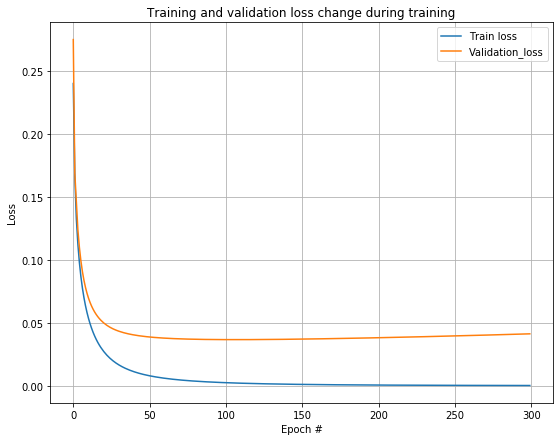

In [84]:
plt.plot(range(len(train_losses)), train_losses, label='Train loss')
plt.plot(range(len(validation_losses)), validation_losses, label='Validation_loss')
plt.title('Training and validation loss change during training')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [86]:
test_data = pd.read_csv('./data/test_data.csv')

In [96]:
test_y = test_data['response'].values
test_y = test_y.reshape(-1, 1)
test_features = test_data.drop(columns='response').values

In [97]:
lr_model.eval()

LogisticRegression(
  (_linear): Linear(in_features=1194, out_features=1, bias=True)
  (_loss): BCELoss()
)

In [98]:
test_features = torch.Tensor(test_features)
test_y = torch.Tensor(test_y)

In [99]:
test_y.shape

torch.Size([308, 1])

In [100]:
predicted = lr_model.forward(test_features.float())
loss = lr_model.loss(out, test_y.float())

In [106]:
predicted = out.detach().numpy().reshape(-1)
real = test_y.detach().numpy().reshape(-1)

<Figure size 648x504 with 0 Axes>

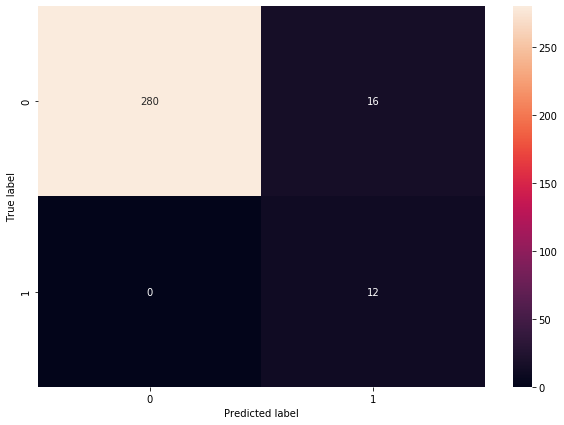

In [115]:
c_mtx = confusion_matrix(real, predicted.round())
df_cm = pd.DataFrame(c_mtx)
fig = plt.figure()
plt.figure(figsize = (10,7))
sns_plot = sns.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [128]:
fpr, tpr, _ = roc_curve(real, predicted.round())

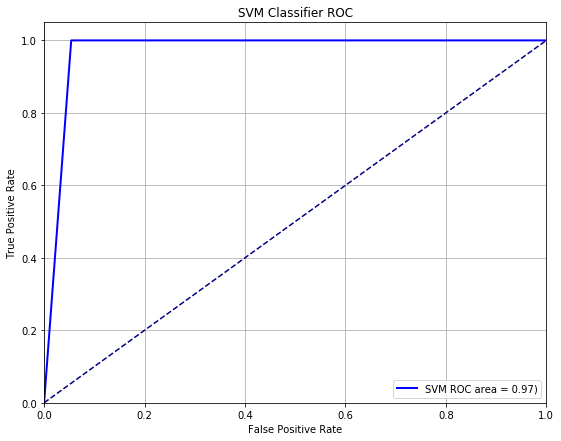

In [132]:
roc_auc = auc(fpr, tpr)
#GRAPH DATA
plt.figure()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('SVM Classifier ROC')
plt.plot(fpr, tpr, color='blue', lw=2, label='SVM ROC area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [134]:
print('Accuracy: {}'.format(accuracy_score(real, predicted.round())))
print('F1 score: {}'.format(f1_score(real, predicted.round())))

Accuracy: 0.948051948051948
F1 score: 0.6
